In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.linalg import eigh
from scipy.signal import hilbert

In [2]:
import pickle

In [3]:
import sys
import os
parent = os.path.dirname(os.getcwd())
sys.path.append(parent+'/my_module')

In [4]:
import chpca as hv

In [5]:
import statsmodels.api as sm

In [6]:
from datetime import datetime

In [7]:
from fredapi import Fred
fred = Fred(api_key="efedf207a63071188c699caf884a4ee9")

In [65]:

def get_fred(arg_list):
    for i in range(len(arg_list)):
        s = arg_list[i]
        if i == 0:
            arg_data = fred.get_series(s)
            print(s)
        else:
            arg_data = pd.concat([arg_data,fred.get_series(s)],axis=1)
            print(s)

    arg_data = arg_data
    arg_data.columns = arg_list
    #arg_data = arg_data.dropna(how='any',axis=0)
    arg_data = arg_data.resample('M').mean()
    print('success')
    return arg_data

In [72]:

daily_list = ['BAMLH0A0HYM2']
weekly_list = ['ICSA']
monthly_list = ['T10YFFM','UMCSENT','PERMIT','JTSJOL','NEWORDER','ACDGNO',
                'PAYEMS','W875RX1','CE16OV','INDPRO']

In [73]:
daily = get_fred(daily_list)
weekly = get_fred(weekly_list)
monthly = get_fred(monthly_list)

BAMLH0A0HYM2
success
ICSA
success
T10YFFM
UMCSENT
PERMIT
JTSJOL
NEWORDER
ACDGNO
PAYEMS
W875RX1
CE16OV
INDPRO
success


In [74]:
data = pd.concat([daily,weekly,monthly],axis=1,join='inner')
data = data.dropna(how='any',axis=0)
data.columns = daily_list+weekly_list+monthly_list
data.head()

,BAMLH0A0HYM2,ICSA,T10YFFM,UMCSENT,PERMIT,JTSJOL,NEWORDER,ACDGNO,PAYEMS,W875RX1,CE16OV,INDPRO
1996-12-31,3.130000,353500.0,1.01,96.9,1411.0,NaN,50765.0,26790.0,121145.0,8442.0,127860.0,77.3731
1997-01-31,3.032727,339000.0,1.33,97.4,1382.0,NaN,51958.0,28524.0,121363.0,8477.0,128298.0,77.5138
1997-02-28,2.951053,320750.0,1.23,99.7,1445.0,NaN,54285.0,29287.0,121675.0,8516.0,128298.0,78.4246
1997-03-31,2.697500,319400.0,1.30,100.0,1436.0,NaN,54195.0,29168.0,121989.0,8555.7,128891.0,78.9266
1997-04-30,2.893182,327000.0,1.38,101.4,1421.0,NaN,55044.0,29915.0,122284.0,8568.6,129143.0,78.9924


In [75]:

data.columns = ['CREDIT SPREAD',
                'ICSA',
                'T10YFFM','UM CSENT','HOUSING PERMIT','JOB VACANCY','NEW ORDER','CONSUMER DGOODS',
                'NONFARM PAYROLL','REAL INCOME exTRANSFER','EMPLOYED','INDUSTRIAL PRODUCTION']
data = data.loc[:,['CREDIT SPREAD','T10YFFM','ICSA','UM CSENT','HOUSING PERMIT',
                   'JOB VACANCY','NEW ORDER','CONSUMER DGOODS',
                   'NONFARM PAYROLL','REAL INCOME exTRANSFER','EMPLOYED','INDUSTRIAL PRODUCTION']]


ref = 'NONFARM PAYROLL'

data = pd.concat([data.iloc[:,:2].diff(),np.log(data.iloc[:,2:]).diff()],axis=1)
data = data.dropna(how='any',axis=0)
data.head()

,CREDIT SPREAD,T10YFFM,ICSA,UM CSENT,HOUSING PERMIT,JOB VACANCY,NEW ORDER,CONSUMER DGOODS,NONFARM PAYROLL,REAL INCOME exTRANSFER,EMPLOYED,INDUSTRIAL PRODUCTION
2001-01-31,-0.550628,0.34,-0.017493,-0.038327,0.096311,0.028291,-0.028309,-0.078197,-0.000143,0.004384,0.001191,-0.004946
2001-02-28,-0.855682,0.43,0.087930,-0.044260,-0.025635,-0.026524,-0.001827,0.061739,0.000655,0.002046,-0.001206,-0.006538
2001-03-31,0.307717,-0.03,0.042066,0.009885,0.001810,-0.067984,-0.042937,0.000929,-0.000264,0.002970,0.001242,-0.002620
2001-04-30,0.587783,0.76,0.024365,-0.034467,0.004211,-0.031356,-0.058519,-0.027055,-0.002232,-0.004045,-0.003519,-0.003557
2001-05-31,-0.814304,0.84,-0.005687,0.039917,-0.000600,-0.042042,0.031553,0.052459,-0.000332,-0.003242,-0.001509,-0.005211


In [90]:
data = data.loc['2021':,:]
data = (data - data.mean())/data.std()

In [91]:
start = datetime.now()

In [92]:
T,N = data.shape
data.shape

(37, 12)

### ヒルベルト変換(固有値は大きい順にソート)

In [93]:
eigenvals, eigenvecs, mode_signal, intensity =hv.make_hilvert(data)
#np.real(eigenvals)

### 累積寄与率

In [94]:
pd.DataFrame(eigenvals.cumsum() / eigenvals.sum()).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.30691,0.487873,0.639804,0.737711,0.810887,0.873074,0.913212,0.943334,0.964971,0.983426,0.994517,1.0


### 固有ベクトル

In [95]:
#eigenvecs.iloc[:,0]

### 検定

In [96]:
sim_num = 1000
input_data = data
chk = hv.make_rss(sim_num,input_data,eigenvals)
chk

ループ処理時間:  0:00:01.606773


,actual,RRS,RTM,RRS_chk,RMT_chk
0,7.166774,6.960068,3.259423,True,True


### 固有ベクトル成分のプロット

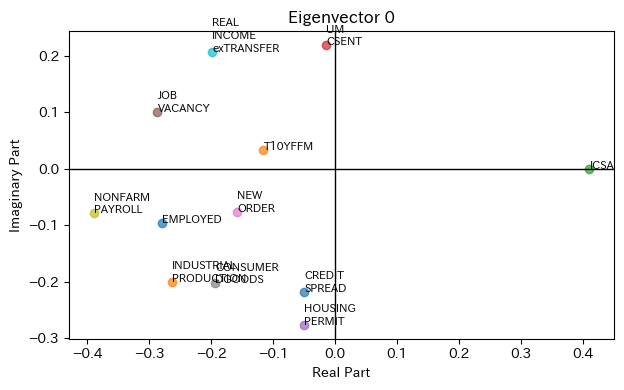

In [97]:
# 固有ベクトルの成分を複素平面にプロット
variable_names = list(eigenvecs.index)
variable_namesX = [s if not s=='DPCCRG' else 'CORE inflation' for s in variable_names]

cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    vec = eigenvecs.loc[:,i].values    
    for j in range(vec.shape[0]):
        plt.scatter(vec[j].real, vec[j].imag, alpha=0.7)
        plt.text(vec[j].real,
                 vec[j].imag,
                 variable_namesX[j].replace(' ','\n'),
                 fontsize=8)

    # 座標軸の表示
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    plt.title(f'Eigenvector {i}')

    k += 1
    
plt.tight_layout()
plt.savefig('img/主要固有ベクトルの成分分布.png')
plt.show()


### 主成分ベクトルの要素の有意水準を計算

In [98]:
sig_mean,sig_std = hv.make_sig(sim_num,data)
pd.DataFrame(sig_mean+2*sig_std).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.310365,0.524484,0.399382,0.692697,0.571388,0.354225,0.583394,0.415788,0.380381,0.214306,0.416803,0.422973


### 各固有ベクトル成分の位相を計算

In [99]:
phase = pd.DataFrame(np.angle(eigenvecs))
phase.index = list(data.columns)
phase = phase / np.pi
abs = np.abs(eigenvecs)

In [100]:

phase,mags = hv.make_phase(eigenvecs,ref)

In [101]:
phase.head()

,0,1,2,3,4,5,6,7,8,9,10,11
CREDIT SPREAD,0.365151,-0.237875,-0.653897,-0.971136,0.661716,0.975236,-0.923253,0.569354,-0.422809,-0.099976,0.790421,-0.376823
T10YFFM,-0.152020,-0.594922,-0.810316,0.290743,0.896889,-0.356363,0.231900,0.774495,0.374739,0.118575,-0.582134,-0.911477
ICSA,0.936410,0.426185,-0.640053,0.043575,-0.904198,0.543337,0.847729,-0.058346,0.130044,-0.532954,-0.072074,-0.741996
UM CSENT,-0.542215,0.733873,0.155037,0.442974,0.471174,-0.061399,0.659183,0.945100,-0.514578,-0.031409,-0.493939,-0.250614
HOUSING PERMIT,0.378517,-0.876183,-0.108088,-0.254377,0.693949,0.948788,-0.049253,-0.784515,0.731528,-0.817281,0.174315,-0.206147


In [102]:
mags.head()

,0,1,2,3,4,5,6,7,8,9,10,11
CREDIT SPREAD,0.222972,0.413629,0.311180,0.093978,0.396840,0.145291,0.126202,0.241843,0.387020,0.322737,0.199597,0.356007
T10YFFM,0.121671,0.461953,0.098182,0.503189,0.193136,0.212577,0.193275,0.161599,0.430337,0.161871,0.370649,0.119269
ICSA,0.410818,0.101152,0.106277,0.172607,0.278359,0.353663,0.286817,0.251206,0.340298,0.348280,0.323617,0.300247
UM CSENT,0.219310,0.431444,0.190386,0.233464,0.171632,0.410732,0.460405,0.122007,0.237052,0.108140,0.042063,0.424656
HOUSING PERMIT,0.280651,0.307937,0.341851,0.246010,0.295044,0.158748,0.242210,0.354604,0.233503,0.214901,0.384228,0.322534


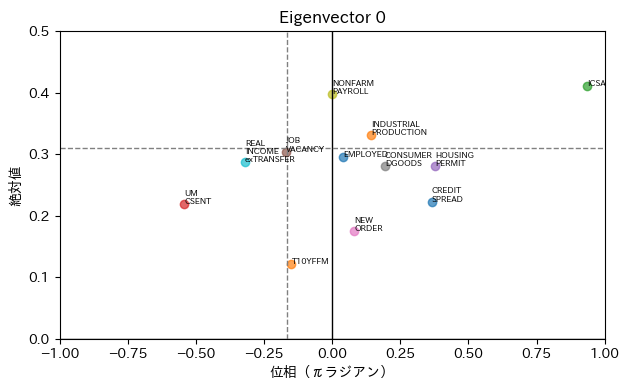

In [103]:
cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    x = phase.loc[:,i].values
    y = mags.loc[:,i].values
    for j in range(x.shape[0]):
        plt.scatter(x[j], y[j], alpha=0.7)
        plt.text(x[j], y[j], variable_namesX[j].replace(' ','\n'), fontsize=6)

    # 座標軸の表示
    plt.xlabel('位相（πラジアン）')
    plt.xlim(-1,1)
    plt.ylim(0,0.5)
    plt.ylabel('絶対値')
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)
    # 有意水準の表示 
    plt.axhline(sig_mean[i]+2*sig_std[i], color='gray', linewidth=1, linestyle='dashed')
    plt.axvline(-1*2/12, color='gray', linewidth=1, linestyle='dashed')
    plt.title(f'Eigenvector {i}')

    k += 1
    
plt.tight_layout()
plt.savefig('img/強度と位相.png')
plt.show()


### モードシグナル

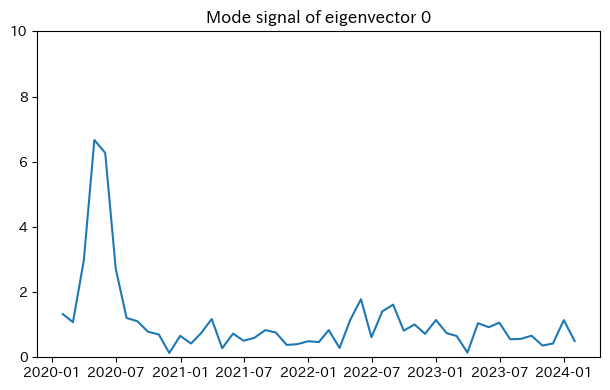

In [28]:
cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

#mode_signal.index = mode_signal.index.to_timestamp()

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    plt.plot(np.abs(mode_signal.loc[:,i]))
    plt.ylim(0,10)
    plt.title(f'Mode signal of eigenvector {i}')
    k += 1
    
plt.tight_layout()
plt.savefig('img/mode_signal.png')
plt.show()

<Axes: >

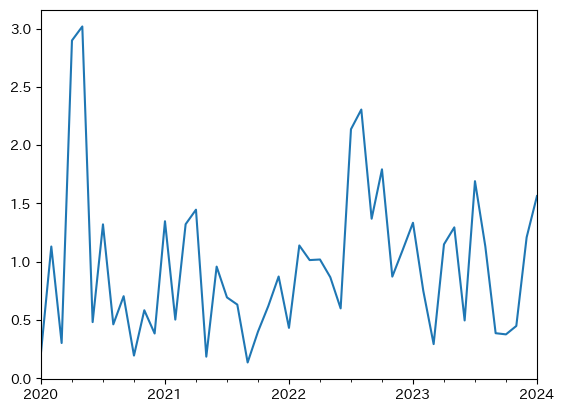

In [40]:
mode_signal.iloc[:,5].plot()

In [34]:
intensity.head()

,0,1,2,3,4,5,6,7,8,9,10
2020-01-31,0.234081,0.050692,0.352895,0.129291,0.013300,0.006456,0.057404,0.056285,0.022176,0.023734,0.053684
2020-02-29,0.026315,0.219177,0.006263,0.263246,0.253708,0.029024,0.021199,0.031812,0.039108,0.026897,0.083250
2020-03-31,0.059493,0.139965,0.107286,0.209700,0.308778,0.000617,0.036511,0.062507,0.006500,0.004706,0.063936
2020-04-30,0.189068,0.070833,0.222075,0.143237,0.220070,0.035730,0.027023,0.048068,0.004070,0.002580,0.037245
2020-05-31,0.254628,0.061111,0.272580,0.120787,0.107823,0.058978,0.017206,0.015611,0.026466,0.027989,0.036823


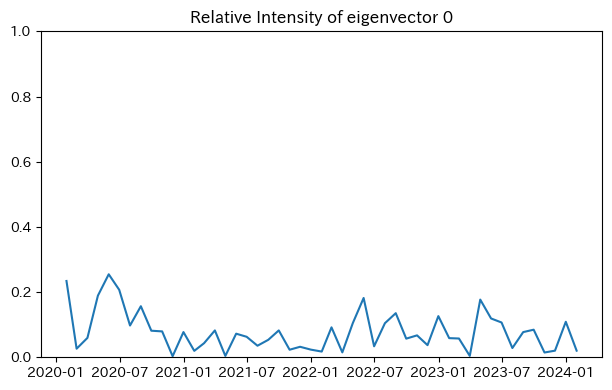

In [29]:
cols = 2  # 1行あたりのサブプロットの数
rows = chk.shape[0] // cols + (chk.shape[0] % cols > 0)  # 必要な行数

plt.figure(figsize=(12, rows * 4))

k = 0
for i in list(chk.index):  # 各固有ベクトルに対して
    plt.subplot(rows, cols, k + 1)  # サブプロットの位置を指定
    plt.plot(intensity.loc[:,i])
    plt.ylim(0,1)
    plt.title(f'Relative Intensity of eigenvector {i}')
    k += 1
    
plt.tight_layout()
plt.savefig('img/主要固有ベクトルの相対強度.png')
plt.show()

### 先行指数の生成

In [ ]:
selected_vars = pd.concat([phase[0],mags[0]],axis=1)
selected_vars.columns = ['phase','mags']

threshold = sig_mean[0]+2*sig_std[0]
selected_vars = selected_vars[(selected_vars['phase']<=0)&(selected_vars['mags']>threshold)]

selected_vars = list(selected_vars.index)
selected_vars = [selected_vars[-1]]+selected_vars[:-1]

In [ ]:

pd.DataFrame(np.imag(eigenvecs.loc[selected_vars,0])).T

In [ ]:

pd.DataFrame(np.angle(eigenvecs.loc[selected_vars,0])).T

In [ ]:
freq = 12
phi = pd.DataFrame(np.angle(eigenvecs.loc[selected_vars,0])/(2*np.pi)*freq-(np.angle(eigenvecs.loc[selected_vars,0])/(2*np.pi)*54)[0]).T
phi.columns = selected_vars
phi.index = ['lead']
phi = phi.T
phi

In [ ]:
phi = phase.loc[selected_vars,0] #πラジアン単位
phi = np.abs((phi / 2) * 54 // 1)
phi

In [ ]:
data_shifted = [data.loc[:,s].shift(int(phi[s])) for s in selected_vars]
data_shifted = pd.concat(data_shifted,axis=1).dropna(how='any',axis=0)
data_shifted.tail()

In [ ]:
data.loc['2024':,(selected_vars)]

In [ ]:

leading_real = np.dot(data_shifted.iloc[:,1:],np.real(eigenvecs.loc[selected_vars[1:],0].values))
leading_real = pd.DataFrame(leading_real)
leading_real.index = list(data_shifted.index)
leading_real.columns = ['実部ベース']
pd.concat([data_shifted.iloc[:,0].cumsum(),leading_real.cumsum()],axis=1).plot()

In [ ]:

leading_abs = np.dot(data_shifted.iloc[:,1:],np.abs(eigenvecs.loc[selected_vars[1:],0].values))
leading_abs = pd.DataFrame(leading_abs)
leading_abs.index = list(data_shifted.index)
leading_abs.columns = ['絶対値ベース']
leading_abs.cumsum().plot()

In [ ]:
#phi = np.imag(eigenvecs.loc[selected_vars,0].values).mean()
#phi = (phi / (2 * np.pi)) * 54

plt.scatter(leading_real.values,leading_abs.values,alpha=0.3)
plt.xlabel('実部ベースの先行指数')
plt.ylabel('絶対値ベースの先行指数')
plt.show()

### 先行指数

In [ ]:

X = leading_abs
X['C'] = 1
#X.columns = ['yen','leading_index','const']
y = data_shifted['yen']

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

In [ ]:
X = leading_real
X['C'] = 1
#X.columns = ['yen','leading_index','const']
y = data_shifted['yen']

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

In [ ]:
y_ = res.fittedvalues
plt.scatter(y_,y)
plt.show()

### 有意な成分の位相差を計算

In [ ]:
phi = np.pi/4
obs_num = 54
# -π/4 に相当する週数を分数で表現
#t_fraction = Fraction(phi / (2 * np.pi)).limit_denominator() * obs_num
leads = (phi / (2 * np.pi)) * obs_num
leads


In [ ]:
print('終わりました: ',datetime.now()-start)

In [ ]:
np.angle(-1+0.5j)/np.pi

In [ ]:
np.angle(-1-0.5j)/np.pi

In [ ]:
-2*2*np.pi/12